# Text Clustering and Topic Modeling

In [1]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

加载数据ArXiv文章： Conputation and Language 

In [2]:
# loading
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")['train']
dataset[0]

C:\Users\hhm18\miniconda3\envs\env_LLM\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


{'Titles': 'Introduction to Arabic Speech Recognition Using CMUSphinx System',
 'Abstracts': '  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n',
 'Years': 2007,
 'Categories': 'Computation and Language'}

In [3]:
abstracts = dataset['Abstracts']
titles = dataset['Titles']
dataset


Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})

## 文本聚类的流程

### 1.文本表示

In [4]:
#abstracts is a list
type(abstracts)

datasets.arrow_dataset.Column

In [5]:
abstracts[0:5]

['  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n',
 '  In this paper we present the creation of an Arabic version of Automated\nSpeech Recognition System (ASR). This system is based on the open source\nSphinx-4, from the Carnegie Mellon University. Which is a speech recognition\nsystem based on discrete hidden Markov models (HMMs). We investigate the\nchanges that must be made to the model to adapt Arabic voice recognition.\n  Keywords: Speech recognition, Acoustic mo

In [6]:
%pip install -U datasets sentence-transformers

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [7]:
from sentence_transformers import SentenceTransformer

# create an embedding for each abstract
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

C:\Users\hhm18\miniconda3\envs\env_LLM\lib\site-packages\transformers\models\bert\modeling_bert.py:419: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [8]:
embeddings.shape #检查维度

(44949, 384)

### 2.文本降维

In [9]:
!pip install umap-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [10]:
# 可以用sklearn降维方法，例如sklearn.decomposition.PCA, t-SNE
from umap import UMAP

# 把输入的embedding 从384维降到5维
umap_model = UMAP(
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

reduced_embeddings = umap_model.fit_transform(embeddings)

C:\Users\hhm18\miniconda3\envs\env_LLM\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
reduced_embeddings.shape #检查维度

(44949, 5)

### 3.降维后的embedding进行聚类

In [12]:
!pip install hdbscan

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [13]:
# 也可以选择其他不同的聚类方法，如sklearn.cluster.KMeans, sklearn.cluster.DBSCAN
# 这里使用HDBSCAN
from hdbscan import HDBSCAN

# Euclidean距离, cluster_selection_method='eom' 选择基于密度的聚类
hdbscan_model = HDBSCAN(
    min_cluster_size=50,
    metric='euclidean',
    cluster_selection_method='eom',).fit(reduced_embeddings)

clusters = hdbscan_model.labels_
len(set(clusters))

C:\Users\hhm18\miniconda3\envs\env_LLM\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hhm18\miniconda3\envs\env_LLM\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


152

### 4.检查聚类的结果

In [14]:
import numpy as np

# 打印前三个类别
abstracts = list(abstracts) # 转换为列表以便索引
cluster = 0
for index in np.where(clusters == cluster)[0][:3]:
    print(abstracts[index][:200] +'...\n')

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesiz...

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focu...

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation syste...



### 静态绘图

In [15]:
import pandas as pd

# reduce 384-dimensional embeddings to 2D for visualization
reduced_embeddings = UMAP(
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=42
).fit_transform(embeddings)

# create a DataFrame for the reduced embeddings
df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
df['title'] = titles
df['cluster'] = [str(c) for c in clusters]

# select outliers and non-outliers
clusters_df = df.loc[df.cluster != '-1', :] # 正常的聚类点
outliers_df = df.loc[df.cluster == '-1', :] #标记为噪声的离群点

C:\Users\hhm18\miniconda3\envs\env_LLM\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


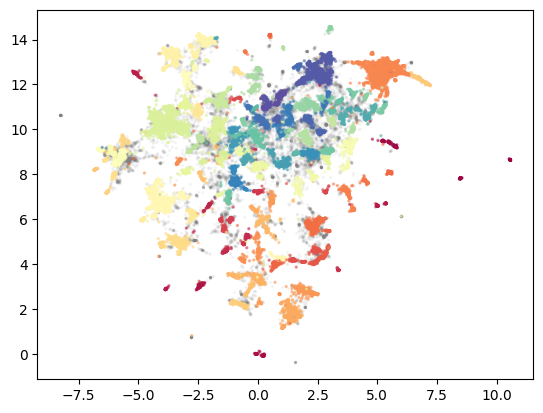

In [16]:
import matplotlib.pyplot as plt

# 分别绘制离群点和非离群点
# alpha-透明度，s-点的大小，cmap-颜色图
plt.scatter(
    outliers_df.x, outliers_df.y, alpha=0.05, s=2, c='gray')
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int), 
    alpha=0.5, s=2, cmap='Spectral')


# 从文本聚类到主题模型

## BERTopic:模块化的主题框架

In [17]:
!pip install bertopic

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [18]:
from bertopic import BERTopic

# train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=False
).fit(abstracts, embeddings)

In [19]:
type(embedding_model)

sentence_transformers.SentenceTransformer.SentenceTransformer

要获取每个主题的前十个关键词和c-TF-IDF权重我们可以使用.get_topic_info()
* TF-IDF（Term Frequency – Inverse Document Frequency）是一种衡量词语对文档重要程度的经典统计方法，最早用于信息检索（IR）和文本挖掘。  
它的核心思想：
一个词语在当前文档中出现次数越多（TF 高），且在整个语料库中越罕见（IDF 高），则它对这篇文档越重要。

In [20]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,13541,-1_the_of_and_to,"[the, of, and, to, in, we, language, for, that...",[ The paper introduces methods of adaptation ...
1,0,2206,0_speech_asr_recognition_end,"[speech, asr, recognition, end, acoustic, spea...","[ Recently, masked prediction pre-training ha..."
2,1,2172,1_question_answer_qa_questions,"[question, answer, qa, questions, answering, a...",[ Question Answering (QA) is one of the most ...
3,2,1451,2_medical_clinical_biomedical_patient,"[medical, clinical, biomedical, patient, healt...",[ Biomedical Named Entity Recognition (NER) i...
4,3,1032,3_translation_nmt_machine_neural,"[translation, nmt, machine, neural, bleu, engl...",[ Document-level machine translation incorpor...
...,...,...,...,...,...
147,146,53,146_emoji_emojis_emoticons_sentiment,"[emoji, emojis, emoticons, sentiment, social, ...",[ The frequent use of Emojis on social media ...
148,147,52,147_coherence_discourse_paragraph_text,"[coherence, discourse, paragraph, text, cohere...",[ While there has been significant progress t...
149,148,51,148_mixed_code_sentiment_mixing,"[mixed, code, sentiment, mixing, analysis, eng...",[ In today's interconnected and multilingual ...
150,149,51,149_propaganda_techniques_news_subtask,"[propaganda, techniques, news, subtask, detect...",[ Propaganda aims at influencing people's min...


In [21]:
topic_model.get_topic(0)

[('speech', 0.028794941924633905),
 ('asr', 0.019281408416716706),
 ('recognition', 0.013710766221639173),
 ('end', 0.010241198335382583),
 ('acoustic', 0.009693357977504743),
 ('speaker', 0.006966291976617824),
 ('audio', 0.0069628066151669905),
 ('the', 0.006496098575647251),
 ('wer', 0.006475029310382875),
 ('error', 0.0064462820722843185)]

In [22]:
topic_model.get_document_info(abstracts)[:10]

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,In this paper Arabic was investigated from t...,-1,-1_the_of_and_to,"[the, of, and, to, in, we, language, for, that...",[ The paper introduces methods of adaptation ...,the - of - and - to - in - we - language - for...,0.000000,False
1,In this paper we present the creation of an ...,-1,-1_the_of_and_to,"[the, of, and, to, in, we, language, for, that...",[ The paper introduces methods of adaptation ...,the - of - and - to - in - we - language - for...,0.000000,False
2,Intelligent Input Methods (IM) are essential...,-1,-1_the_of_and_to,"[the, of, and, to, in, we, language, for, that...",[ The paper introduces methods of adaptation ...,the - of - and - to - in - we - language - for...,0.000000,False
3,This paper includes a reflection on the role...,-1,-1_the_of_and_to,"[the, of, and, to, in, we, language, for, that...",[ The paper introduces methods of adaptation ...,the - of - and - to - in - we - language - for...,0.000000,False
4,"We test a segmentation algorithm, based on t...",27,27_law_zipf_frequency_words,"[law, zipf, frequency, words, of, texts, rank,...","[ Human language, as a typical complex system...",law - zipf - frequency - words - of - texts - ...,0.221172,False
5,This paper describes the Linguistic Annotati...,122,122_annotation_tools_formats_linguistic,"[annotation, tools, formats, linguistic, annot...",[ Data annotation is an important and necessa...,annotation - tools - formats - linguistic - an...,1.000000,False
6,We show that a general model of lexical info...,122,122_annotation_tools_formats_linguistic,"[annotation, tools, formats, linguistic, annot...",[ Data annotation is an important and necessa...,annotation - tools - formats - linguistic - an...,1.000000,False
7,This research hypothesized that a practical ...,-1,-1_the_of_and_to,"[the, of, and, to, in, we, language, for, that...",[ The paper introduces methods of adaptation ...,the - of - and - to - in - we - language - for...,0.000000,False
8,This dissertation presents several new metho...,40,40_sense_wsd_senses_word,"[sense, wsd, senses, word, disambiguation, emb...",[ Acquisition of multilingual training data c...,sense - wsd - senses - word - disambiguation -...,1.000000,False
9,This paper describes experiments on learning...,-1,-1_the_of_and_to,"[the, of, and, to, in, we, language, for, that...",[ The paper introduces methods of adaptation ...,the - of - and - to - in - we - language - for...,0.000000,False


我们可以使用find_topics()查找特定主题

In [23]:
topic_model.find_topics("topic modeling", top_n=5)

([26, -1, 2, 52, 31], [0.95471686, 0.9119856, 0.9075406, 0.9072879, 0.9056414])

结果显示相似度最高的主题为26（0.95相似度）我们可以进一步查看这个主题是否符合预期：

In [24]:
topic_model.get_topic(26)

[('topic', 0.0688543631351002),
 ('topics', 0.035830759637663016),
 ('lda', 0.016503765788859467),
 ('latent', 0.013350227624221816),
 ('documents', 0.012659777841898357),
 ('document', 0.012407550885646325),
 ('modeling', 0.012248062603326225),
 ('dirichlet', 0.010147662712888117),
 ('word', 0.008680881204544274),
 ('allocation', 0.007986729733747939)]

## 文档的可视化

In [25]:
!pip install -U plotly  
# 如已装可跳过

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [26]:
# reduced_embeddings 是你事先算好的 (n_samples, 2) 数组
fig = topic_model.visualize_documents(
    abstracts,                       # 原始文本
    reduced_embeddings=reduced_embeddings,
    hide_annotations=True,
    width=1000,
    title="Topics in Research Abstracts"
)

fig.show(renderer="browser")

In [27]:
fig = topic_model.visualize_topics(
    title="Topics in Research Abstracts",
    width=800
)
fig.show()

In [28]:
topic_model.visualize_barchart(top_n_topics=10, width=500)

In [29]:
topic_model.visualize_heatmap(n_clusters=50 ,width=800)

##  4.模型表示

In [30]:
# # 在训练开始之前使用表示模型，按照以下的方式运行：
# from bertopic.representation import KeyBERTInspired
# from bertopic import BERTopic

# # create your respresentation model
# representation_model = KeyBERTInspired()

# # use the representation model in BERTopic on top of dedault pipeline
# topic_model = BERTopic(representation_model=representation_model)
    

为了使用表示模型我们首先复制主题模型，这样更方便的展示表示模型的作用

In [31]:
# 保存原始表示
from copy import deepcopy
original_topic_model = deepcopy(topic_model.topic_representations_)

In [32]:
def topic_difference(model, original_topic_model, nr_topic=5):
    """显示两个模型主题表示的差异"""
    df = pd.DataFrame(columns=['Topic', 'Original', 'New'])

    for topic in range(nr_topic):
        # 显示每个主题模型前五的关键词
        og_words = " | ".join(list(zip(*original_topic_model[topic]))[0][:5])
        new_words =  " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]
    return df

In [33]:
### KeyBERTInspired
from bertopic.representation import KeyBERTInspired

# 更新我们的主题表示为KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# 显示主题表示的差异性
topic_difference(topic_model, original_topic_model, nr_topic=5)

,Topic,Original,New
0,0,speech | asr | recognition | end | acoustic,phonetic | decoding | language | transcription...
1,1,question | answer | qa | questions | answering,answering | questions | comprehension | answer...
2,2,medical | clinical | biomedical | patient | he...,nlp | clinical | ehr | ehrs | annotated
3,3,translation | nmt | machine | neural | bleu,translation | translate | translations | monol...
4,4,summarization | summaries | summary | abstract...,summarization | summarizers | summaries | summ...


In [34]:
## Maximal Marginal Relevance (MMR)
from bertopic.representation import MaximalMarginalRelevance

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# 显示主题表示的差异性
topic_difference(topic_model, original_topic_model, nr_topic=5)

,Topic,Original,New
0,0,speech | asr | recognition | end | acoustic,speech | asr | audio | error | model
1,1,question | answer | qa | questions | answering,questions | retrieval | comprehension | to | hop
2,2,medical | clinical | biomedical | patient | he...,clinical | biomedical | patient | healthcare |...
3,3,translation | nmt | machine | neural | bleu,translation | nmt | bleu | parallel | multilin...
4,4,summarization | summaries | summary | abstract...,summarization | document | extractive | rouge ...


*一些区别*
| 维度        | KeyBERT                                                                                                                   | MMR（Maximal Marginal Relevance）                                                                                       |
| --------- | ------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------- |
| **本质**    | 关键词抽取库/方法                                                                                                                 | 一种“重排序”策略，常与 KeyBERT 结合使用                                                                                             |
| **目标**    | 找出与文档语义最相关的前 N 个关键词                                                                                                       | 在保证“与文档相关”的同时，减少关键词之间的冗余                                                                                              |
| **默认做法**  | 按 **cosine(文档向量, 候选词向量)** 降序排序，取前 N 个                                                                                     | 在候选池里 **迭代挑选**：<br>`score = λ·rel(doc, ki) − (1−λ)·max rel(ki, kj)`，其中 `kj` 已选                                        |
| **多样性控制** | 无（可能出现“climate change / global warming / climate crisis”等相似词）                                                             | 通过参数 `λ` 与相似度惩罚项显式控制多样性                                                                                               |
| **使用方式**  | `KeyBERT().extract_keywords(doc)`                                                                                         | `KeyBERT().extract_keywords(doc, use_mmr=True, diversity=0.7)`                                                        |
| **计算开销**  | 仅一次向量相似度计算，速度最快                                                                                                           | 每轮都要计算与已选词的相似度，耗时略高                                                                                                   |



# 生成类模型做文本聚类

In [35]:
# flan—T5
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """"I have a topic that contains the following documents: 
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'

Based on the documents and keywords, What is this topic about?
"""

generator = pipeline(
    "text2text-generation",
    model="google/flan-t5-large",
    device="cuda:0"
)

representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace")

topic_model.update_topics(abstracts, representation_model=representation_model)
# 显示主题表示的差异性
topic_difference(topic_model, original_topic_model, nr_topic=5)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,Topic,Original,New
0,0,speech | asr | recognition | end | acoustic,Speech-to-speech translation: a review of the ...
1,1,question | answer | qa | questions | answering,Multilingual Question Answering with Neural Ne...
2,2,medical | clinical | biomedical | patient | he...,Using computational systems for the extraction...
3,3,translation | nmt | machine | neural | bleu,A hybrid search for attention-based neural mac...
4,4,summarization | summaries | summary | abstract...,Query-Based Abstractive Summarization for Beng...


In [ ]:
!pip install -U datamapplot

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

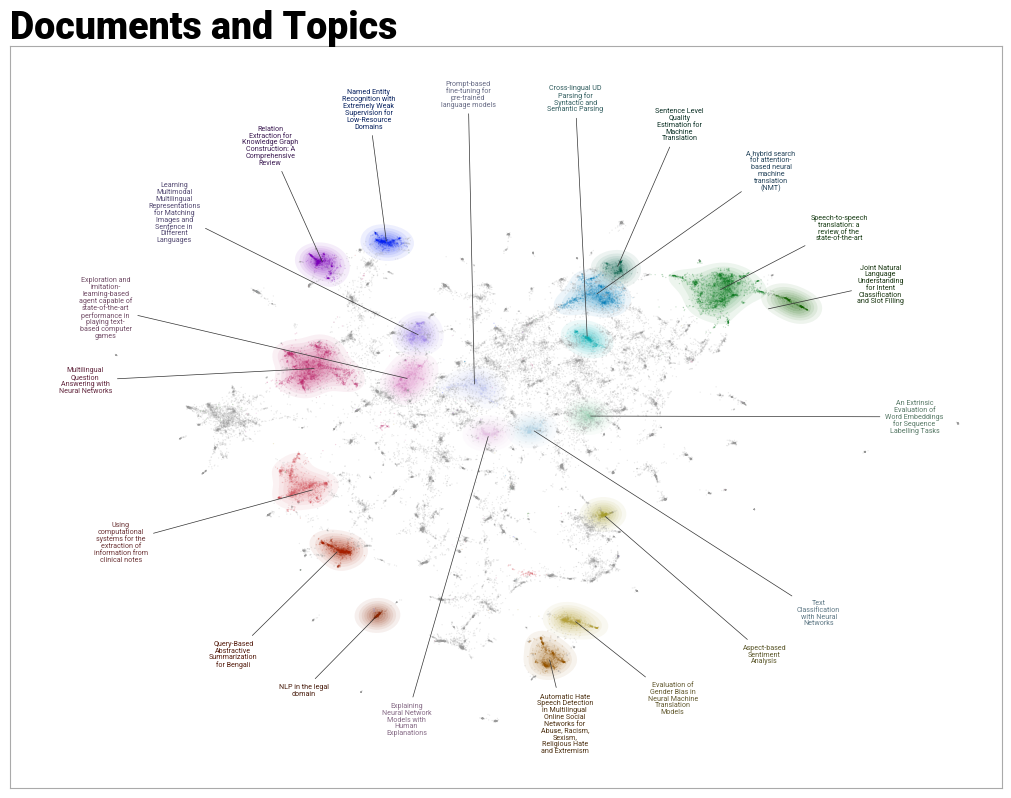

In [39]:
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),          
    reduced_embeddings=reduced_embeddings,
    width=1000
)
plt.show()

# BONSUS 词云

In [ ]:
!pip install wordcloud